### Linear Regression With Iterative Optimization: `SGDRegressor`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(306)

In [3]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [4]:
features, labels = fetch_california_housing(return_X_y=True, as_frame=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [5]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

# Baseline `SGDRegressor`
- **STEP 1**: Instantiate `SGDRegressor` object with default parameters.
- **STEP 2**: Train the model.
- **STEP 3**: Obtain score on training and development set.

In [6]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print(f'MAE on training set: {train_mae}')
print(f'MAE on development set: {dev_mae}')

MAE on training set: 309190327803747.2
MAE on development set: 311959782899622.1


- Observe that MAE is too high. The baseline model does not train well.

### Adding Feature Scaling Step
- SGD is sensitive to feature scaling. Let's check if this improves MAE.

In [8]:
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor())
])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print(f'MAE on training set: {train_mae}')
print(f'MAE on development set: {dev_mae}')

MAE on training set: 0.5135804404077051
MAE on development set: 0.6373131245753217


# Step-wise Training of `SGDRegressor`

In [14]:
eta0 = 1e-2
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=1, tol=1e-9,warm_start=True, random_state=42))
])

loss=[]
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\918

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

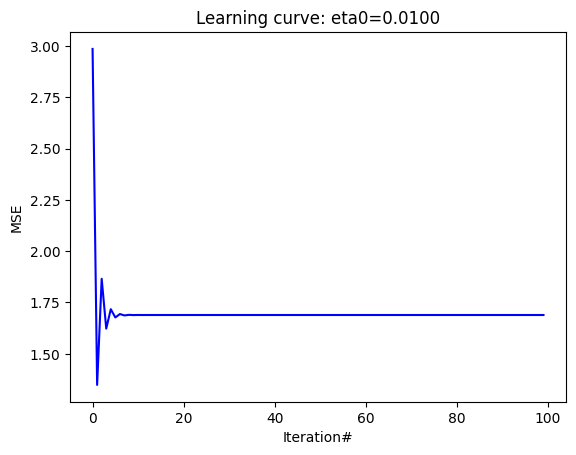

In [15]:
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

Loss decreased initially but then increased. This could be due to **large
learning rate**. Let's try again by reducing the learning rate by a factor of 10.

In [18]:
eta0 = 1e-3 # Reduced learning rate by a factor of 10
sgd_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=1, tol=1e-9,warm_start=True, random_state=42, eta0=eta0))
])

loss=[]
for epoch in range(100):
    sgd_pipeline.fit(train_features, train_labels)
    loss.append(mean_squared_error(train_labels, sgd_pipeline.predict(train_features)))

c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\91820\Desktop\MLP-IIT\.env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\918

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

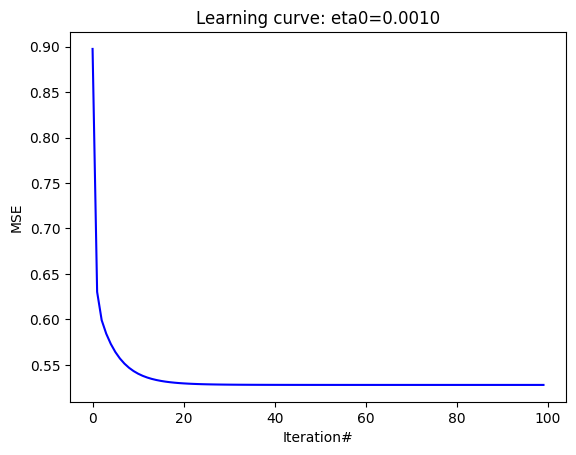

In [19]:
plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

This is an ideal learning curve where the loss **decreases monotonically**.

In [20]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))

print(f'MAE on training set: {train_mae}')
print(f'MAE on development set: {dev_mae}')

MAE on training set: 0.5333732983042573
MAE on development set: 0.5190150280908042


# Fixing Learning Rate Through Validation Curves
- **STEP 1**: Provide list of hyper parameters to be tried
- **STEP 2**: Instantiate an object of `validation_score`.
- **STEP 3**: Convert scores to error.
- **STEP 4**: Plot the validation curve.
- **STEP 5**: Fix the hyper-parameter value where the test error is the least.

In [21]:
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(
    sgd_pipeline, com_train_features, com_train_labels, param_name='sgd__eta0',
    param_range=eta0, n_jobs=2
)

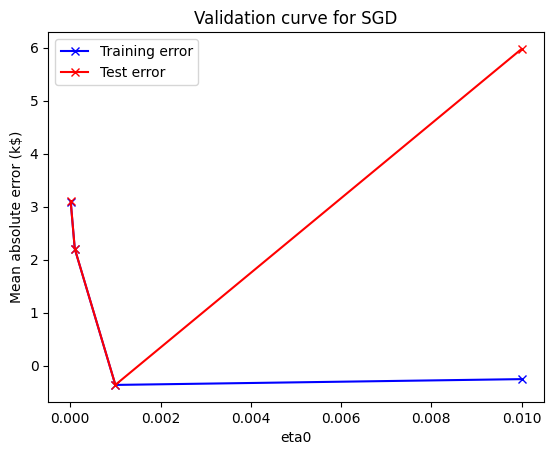

In [22]:
train_errors, test_errors = -train_scores, -test_scores
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="Test error")
plt. legend()

plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for SGD")

For `eta0=1e-3` the test error is the least so fix `eta0=1e-3`

# `SGDRegressor`

In [29]:
sgd_pipeline = Pipeline(
    [
        ("feature_scaling", StandardScaler()),
        ("sgd",
            SGDRegressor(
                max_iter=500,
                early_stopping=True,
                eta0=1e-3,
                tol=1e-3,
                validation_fraction=0.2,
                n_iter_no_change=5,
                average=10,
                random_state=42,
            ),
        ),
    ]
)
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features) )
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5433287489797834
Mean absolute error on development set:  0.5345612073911922
Number of SGD iterations:  35
Number of weight updates:  406351.0


In [30]:
sgd_pipeline = Pipeline(
    [
        ("feature_scaling", StandardScaler()),
        ("sgd",
            SGDRegressor(
                max_iter=500,
                early_stopping=True,
                eta0=1e-3,
                tol=1e-3,
                validation_fraction=0.2,
                n_iter_no_change=5,
                average=10,
                random_state=42,
                learning_rate='constant'
            ),
        ),
    ]
)
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features) )
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5528203432984674
Mean absolute error on development set:  0.5689568216133667
Number of SGD iterations:  11
Number of weight updates:  127711.0


In [31]:
sgd_pipeline = Pipeline(
    [
        ("feature_scaling", StandardScaler()),
        ("sgd",
            SGDRegressor(
                max_iter=500,
                early_stopping=True,
                eta0=1e-3,
                tol=1e-3,
                validation_fraction=0.2,
                n_iter_no_change=5,
                average=10,
                random_state=42,
                learning_rate='adaptive'
            ),
        ),
    ]
)
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features) )
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5375525445454805
Mean absolute error on development set:  0.5200254740759911
Number of SGD iterations:  40
Number of weight updates:  464401.0


# Setting `max_iters`

In [32]:
max_iter = np.ceil(1e6 / com_train_features.shape[0])
max_iter

65.0

In [33]:
sgd_pipeline = Pipeline(
    [
        ("feature_scaling", StandardScaler()),
        ("sgd",
            SGDRegressor(
                max_iter=65,
                early_stopping=True,
                eta0=1e-3,
                tol=1e-3,
                validation_fraction=0.2,
                n_iter_no_change=5,
                average=10,
                random_state=42,
            ),
        ),
    ]
)
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features) )
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print ("Mean absolute error on Training set: ", train_mae)
print ("Mean absolute error on development set: ", dev_mae)

print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates: ", sgd_pipeline[-1].t_)

Mean absolute error on Training set:  0.5433287489797834
Mean absolute error on development set:  0.5345612073911922
Number of SGD iterations:  35
Number of weight updates:  406351.0
